In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.sql import func
from sqlalchemy import inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
Station

sqlalchemy.ext.automap.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

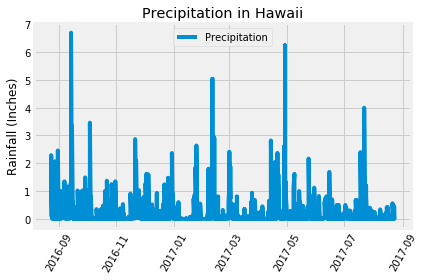

datetime.datetime(2017, 8, 23, 0, 0)

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
hawaii_recent_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
    
for date in hawaii_recent_date:
    very_recent_date = date.date

very_recent_date = dt.datetime.strptime(very_recent_date, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = very_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
hawaii_recent_prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(hawaii_recent_prcp_data).dropna()

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df['date'], df['prcp'],label = 'Precipitation')
plt.title("Precipitation in Hawaii")
plt.ylabel('Rainfall (Inches)')

# Rotate the xticks for the dates
plt.xticks(rotation='60')

# Create legend.
plt.legend(loc='upper center')

plt.tight_layout()
plt.savefig("Images/Precipitation in Hawaii")
plt.show()
very_recent_date

![precipitation](Images/precipitation.png)

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [11]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

hawaiistation = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
hawaiistation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
very_active_station = session.query(Measurement.station, 
                                    func.count(Measurement.station).label('count')).\
                                    group_by(Measurement.station).\
                                    order_by(Measurement.tobs.desc())
select = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
session.query(*select).filter(Measurement.station=="USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

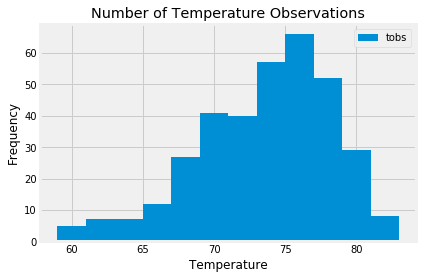

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram  = session.query(Measurement.tobs).\
                                filter(Measurement.station=="USC00519281").\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()

x = [x[0] for x in histogram]

plt.title("Number of Temperature Observations")

plt.hist(x, bins=12,label = 'tobs')

# Create legend.
plt.legend(loc='upper right')

plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.savefig("Images/Number of Temperature Observations")
plt.show()

![precipitation](Images/station-histogram.png)

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2012-02-28', '2012-03-05')
temps


[(62.0, 69.57142857142857, 74.0)]

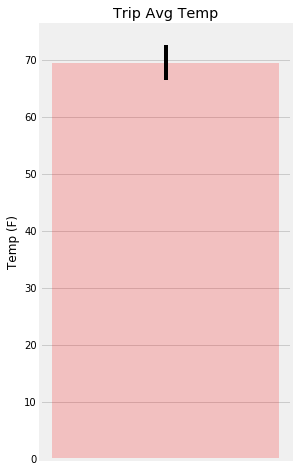

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(4,8))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='red', alpha=0.2)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(0)
plt.savefig("Images/Trip Avg Temp")
plt.show()

In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#set trip dates and previous dates
tripStartDate = '2017-07-01'
tripEndDate = '2017-01-08'

select = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])


stationRain = (session.query(*select)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= tripStartDate)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert to data frame
stationRainTable = pd.DataFrame(np.array(stationRain))
#rename all the columns
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                
                                                    4: "Longitude", 5: "Elevation"})

stationRainTable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",18.320000000000007,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",4.279999999999999,21.45167,-157.84888999999998,32.9
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2.7999999999999994,21.5213,-157.8374,7.0
3,USC00513117,"KANEOHE 838.1, HI US",2.16,21.4234,-157.8015,14.6
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.85,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.48000000000000004,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.01,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
tripStartDate = "2017-07-01"
tripEndDate = "2017-01-08"

#calculating the trip length
StartNum = int(tripStartDate[-2:])
EndNum = int(tripEndDate[-2:])
tripLength = EndNum - StartNum + 1

# Use the start and end date to create a range of dates
tripStartDate = dt.datetime.strptime(tripStartDate, '%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings
dateList = [dt.datetime.strftime(tripStartDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

# Loop through the list of %m-%d strings and calculate the normals for each date
tripNormals = [daily_normals(date) for date in dateList]

tripNormals

[[(67.0, 74.77777777777777, 81.0)],
 [(68.0, 75.40384615384616, 82.0)],
 [(68.0, 75.32075471698113, 87.0)],
 [(70.0, 76.57142857142857, 81.0)],
 [(66.0, 75.0, 81.0)],
 [(69.0, 75.0, 81.0)],
 [(69.0, 74.91071428571429, 82.0)],
 [(69.0, 76.08333333333333, 83.0)]]

In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripNormals = [np.array(normal[0]) for normal in tripNormals]
normalsTable = pd.DataFrame(tripNormals)
normalsTable["Date"] = dateList
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp",  1:"Avg Temp", 2: "High Temp"})

normalsTable


,Low Temp,Avg Temp,High Temp
Date,,,
07-01,67.0,74.777778,81.0
07-02,68.0,75.403846,82.0
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0
07-06,69.0,75.000000,81.0
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0


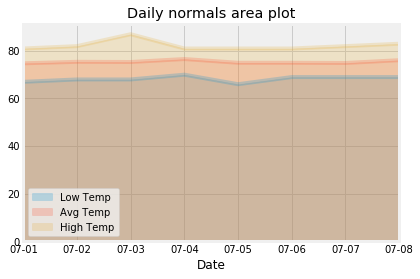

In [33]:
# Plot the daily normals as an area plot with `stacked=False`
normalsTable.plot.area(stacked=False, alpha=.222)
plt.title('Daily normals area plot')
plt.savefig("Images/Daily normals as an area plot")
plt.show()